# Reinforcement Learning Agent
Here we try to develop a RL Agent for learning the game of blackjack. We use Q-Learning for the same.

In [1]:
from game import *
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  
import random
from matplotlib.pyplot import figure

 **Enlist Valid States**  
 
The player state consists of three fields:
1. Integer representing the sum of player card values
2. Integer representing the value of dealer's first card
3. Boolean representing whether the player has a usable Ace.

First we write a function to get the current agent state. Then we enlist all the valid states that the player can be in. The player can continue playing (choosing between hit and state) in the valid states. We also assign an integer index to each state for easy reference. 

In [2]:
def get_state(game):
    return (game.get_sum(game.get_player_hand()), game.get_hand_value(game.get_dealer_hand())[0], game.hasAce)

valid_states = [(x,y,z) for z in [True,False] for x in range(12,22) for y in range(2,12)]
states_without_ace = [(x,y,False) for x in range(12,22) for y in range(2,12)]
states_with_ace = [(x,y,True) for x in range(12,22) for y in range(2,12)]

def state_to_index(st):
    if st in valid_states:
        return valid_states.index(st)
    else:
        return -1

state_to_index((20, 2, True))
state_to_index((22, 2, True))

-1

**Initialize Q-value Table** 

SARSA learning assigns a q-value to each state,action pair which represents the future rewards expected to be received if we take the given action in the given state. The actions that a player can take in any valid state are: hit and stand. We assign a q-value of 0 to each state, action pair.

In [3]:
def zero_q_values():
    qvals = {"hit": 0.0, "stand": 0.0}
    return qvals

q_value_table = [zero_q_values() for x in valid_states ]
q_value_table[state_to_index((20, 2, True))]

{'hit': 0.0, 'stand': 0.0}

**Epsilon-Greedy Policy**  

All control problems need a policy to decide what action to take in what state. We use epsilon-greedy policy, which tells us to take a random action epsilon number of times (exploration) and the best action according to current data 1-epsilon number of times (exploitation).

In [4]:
def epsilon_greedy(epsilon, q_values):
    if random.random() < epsilon:
        return random.choice(list(q_values.keys()))
    else:
        if q_values["hit"] > q_values["stand"]:
            return "hit"
        elif q_values["hit"] < q_values["stand"]:
            return "stand"
        else:
            return random.choice(list(q_values.keys()))

**SARSA**  

Finally we go on to learn the Q-value table. We use SARSA learning algorithm for the same. The intuition behind SARSA is very simple.

We first randomly initialize q_value_table, with zero value for the terminal states. Then everytime we take action a in state s, we try to find the next state s' and next action (according to the same policy) a' and calculate the expected future reward. The expected future reward is given by:   
immediate_reward + GAMMA * Q(s',a')  
GAMMA is the discounting factor in the above equation.  

The Q value of current state and action pair (s,a) is the moving average of all these expected future rewards. Thus we try to move the value of Q(s,a) towards the expected future reward by a constant averaging factor ALPHA.

The policy that we try to learn is the epsilon-greedy policy. However, if we keep exploring at the same rate throughout, our Q-values will never converge. To get the Q-values to converge, we reduce the amount of exploration (value of epsilon) as we learn from more and more experience. Thus we finally get our Q-values to converge to the optimal q-values.

In [5]:
EPSILON = 0.9
ALPHA = 0.05
GAMMA = 0.9
EPISODES = 600000
GLIE_EPISODE = 60000
glie_factor = 1
#count_of_busts = 0
#count_of_wins = 0

q_value_table = [zero_q_values() for x in valid_states ]
for episode in range(EPISODES):
    if (episode % GLIE_EPISODE) == 0:
        EPSILON = EPSILON/glie_factor
        glie_factor += 1
    game = BlackJack()
    game.start_game()
    state = state_to_index(get_state(game))
    action = epsilon_greedy(EPSILON, q_value_table[state])
    while(True):
        if action=="hit":
            game.hit()
            next_state = state_to_index(get_state(game))
        else:
            game.stand()
            next_state = -1
        if next_state == -1:
            q_value_table[state][action] += ALPHA*(game.result - q_value_table[state][action])
            break
        next_action = epsilon_greedy(EPSILON, q_value_table[next_state])
        q_value_table[state][action] += ALPHA*( GAMMA*q_value_table[next_state][next_action] - q_value_table[state][action])
        state = next_state
        action = next_action

**Policy Table**

Finally we try to develop the optimal policy from the Q value table we developed. pi(s) = argmax Q(s,a). We also develop the value table, using the formula v(s) = max Q(s,a)

In [6]:
policy_function = {}
value_function = {}
for state in range(len(valid_states)):
    if q_value_table[state]["hit"] > q_value_table[state]["stand"]:
        policy_function[valid_states[state]] = "hit"
        value_function[valid_states[state]] = q_value_table[state]["hit"]
    else:
        policy_function[valid_states[state]] = "stand"
        value_function[valid_states[state]] = q_value_table[state]["stand"]

**Plotting**

Now having learned the optimal policy, let us plot the policy against the current state, so that we can visualize better.

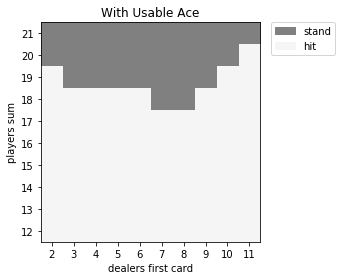

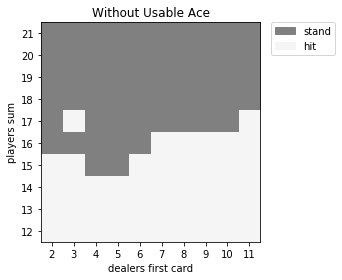

In [7]:
def plotPolicy(policy_table):
    plotMatrix(policy_table, with_ace = True)
    plotMatrix(policy_table, with_ace = False)

def plotMatrix(policy_table, with_ace):
    player_sum = np.arange(12, 22, dtype=int)
    dealer_first_card = np.arange(2,12,dtype=int)
    reversed_player_sum = player_sum[::-1]
    optimal_strategy = np.zeros([player_sum.size, dealer_first_card.size])

    for x in range(12,22): 
        for y in range(2,12):
            if str(policy_table[(x,y,with_ace)]) == 'hit':
                optimal_strategy[x-12][y-2] = 1
    inv_optimal_strategy = optimal_strategy[::-1]

    fig, ax = plt.subplots()
    cmap = colors.ListedColormap([ 'grey','whitesmoke'])
    im = plt.imshow( inv_optimal_strategy, cmap=cmap)
    ax.set_xticks(np.arange(len(dealer_first_card)))
    ax.set_yticks(np.arange(len(reversed_player_sum)))
    ax.set_xticklabels(dealer_first_card)
    ax.set_yticklabels(reversed_player_sum)
    hit_patch = mpatches.Patch(color='whitesmoke', label='hit')
    stand_patch = mpatches.Patch(color='grey', label='stand')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,handles=[stand_patch,hit_patch])
    if with_ace:
        ax.set_title("With Usable Ace")
    else:
        ax.set_title("Without Usable Ace")
    plt.xlabel('dealers first card')
    plt.ylabel('players sum')
    fig.tight_layout()
    plt.show()
    
plotPolicy(policy_function)

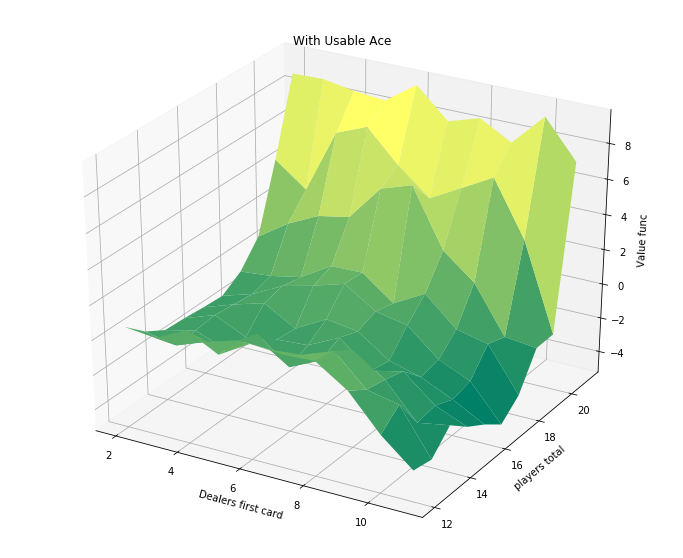

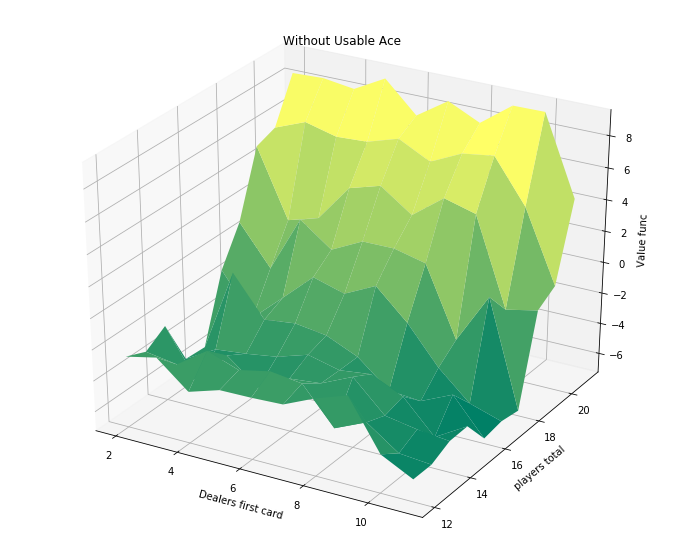

In [8]:
def plot_value_function(value_function, with_ace):

    def fun_with_ace(x, y, with_ace):
        z = np.empty(0)
        for a, b in zip(x,y):
            z = np.append(z , np.array([value_function[(b , a, with_ace)]]))
        return z

    
    fig = plt.figure(num=None, figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(2,12,dtype=int)
    y = np.arange(12, 22, dtype=int)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun_with_ace(np.ravel(X), np.ravel(Y), with_ace))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap = 'summer' )
    ax.set_xlabel('Dealers first card')
    ax.set_ylabel('players total')
    ax.set_zlabel('Value func')
    
    if with_ace:
        ax.set_title("With Usable Ace")
    else:
        ax.set_title("Without Usable Ace")

    plt.show()
plot_value_function(value_function=value_function, with_ace = True)
plot_value_function(value_function=value_function, with_ace = False)

**Q-Learning**

The SARSA technique that we implemented above is an on-policy learning method. On-policy learning means that we can also follow the policy (take actions according to the policy) that we want to learn the q-values for. Q-Learning  is an off-policy learning method. In off-policy learning we want to learn the q-values for one policy, but we follow a different policy for taking actions. This is helpful when we have collect data using some policy but want to learn Q-values using a different policy. Or when we can just observe an agent that is interacting with the environment (we can't control the actions that the agent takes) but still want to learn the optimal policy.

The behavioral policy (according to which we take the actions) that we will use is still epsilon-greedy. But the policy that we are trying to learn (pi) is the greedy policy. Below we code up Q-Learning technique for blackjack.

In [9]:
def greedy_policy(q_values):
    if q_values["hit"] > q_values["stand"]:
        return "hit"
    elif q_values["hit"] < q_values["stand"]:
        return "stand"
    else:
        return random.choice(list(q_values.keys()))
        
EPSILON = 0.1
ALPHA = 0.005
GAMMA = 0.5
EPISODES = 600000
GLIE_EPISODE = 100000 
glie_factor = 1
# count_of_busts = 0
# count_of_wins = 0

q_value_table = [zero_q_values() for x in valid_states ]
visit_count = np.zeros(len(q_value_table))
for episode in range(EPISODES):
#     if (episode % GLIE_EPISODE) == 0:
#         EPSILON = EPSILON/glie_factor
#         glie_factor += 1
    game = BlackJack()
    start_state = random.choice(valid_states)
    ps, dc, ace = start_state
    game.set_state(ps, dc, ace)
    state = state_to_index(get_state(game))
    action = epsilon_greedy(EPSILON, q_value_table[state])
    while(True):
        visit_count[state] += 1 
        if action=="hit":
            game.hit()
            next_state = state_to_index(get_state(game))
        else:
            game.stand()
            next_state = -1
        if next_state == -1:
            q_value_table[state][action] += ALPHA*(game.result - q_value_table[state][action])
            break
        greedy_action = greedy_policy(q_value_table[next_state])
        next_action = epsilon_greedy(EPSILON, q_value_table[next_state])
        q_value_table[state][action] += ALPHA*( GAMMA*q_value_table[next_state][greedy_action] - q_value_table[state][action])
        state = next_state
        action = next_action

In [10]:
policy_function = {}
value_function = {}
for state in range(len(valid_states)):
    if q_value_table[state]["hit"] > q_value_table[state]["stand"]:
        policy_function[valid_states[state]] = "hit"
        value_function[valid_states[state]] = q_value_table[state]["hit"]
    else:
        policy_function[valid_states[state]] = "stand"
        value_function[valid_states[state]] = q_value_table[state]["stand"]
        
print(visit_count.min())
print(visit_count.max())
print(valid_states[visit_count.argmin()])
print(valid_states[visit_count.argmax()])

2886.0
7496.0
(12, 10, True)
(17, 11, False)


**Plotting**   
Here we plot the value function and policy function that we learnt from Q-Learning technique.  

The value function of a state gives the expected reward, given we take the best action possible at that state. It is represented by V(s) = max Q(s,a)  

The policy function is the best action to take at any given state. It is given by pi(s) = argmax Q(s,a)

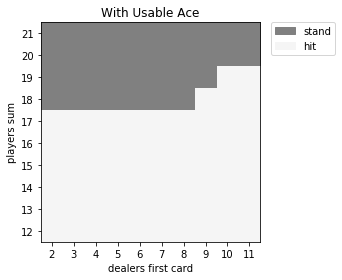

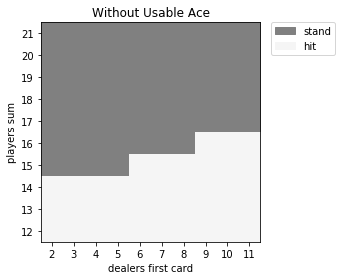

In [13]:
def plotPolicy(policy_table):
    plotMatrix(policy_table, with_ace = True)
    plotMatrix(policy_table, with_ace = False)

def plotMatrix(policy_table, with_ace):
    player_sum = np.arange(12, 22, dtype=int)
    dealer_first_card = np.arange(2,12,dtype=int)
    reversed_player_sum = player_sum[::-1]
    optimal_strategy = np.zeros([player_sum.size, dealer_first_card.size])

    for x in range(12,22): 
        for y in range(2,12):
            if str(policy_table[(x,y,with_ace)]) == 'hit':
                optimal_strategy[x-12][y-2] = 1
    inv_optimal_strategy = optimal_strategy[::-1]

    fig, ax = plt.subplots()
    cmap = colors.ListedColormap([ 'grey','whitesmoke'])
    im = plt.imshow( inv_optimal_strategy, cmap=cmap)
    ax.set_xticks(np.arange(len(dealer_first_card)))
    ax.set_yticks(np.arange(len(reversed_player_sum)))
    ax.set_xticklabels(dealer_first_card)
    ax.set_yticklabels(reversed_player_sum)
    hit_patch = mpatches.Patch(color='whitesmoke', label='hit')
    stand_patch = mpatches.Patch(color='grey', label='stand')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,handles=[stand_patch,hit_patch])
    if with_ace:
        ax.set_title("With Usable Ace")
    else:
        ax.set_title("Without Usable Ace")
    plt.xlabel('dealers first card')
    plt.ylabel('players sum')
    fig.tight_layout()
    plt.show()
    
plotPolicy(policy_function)

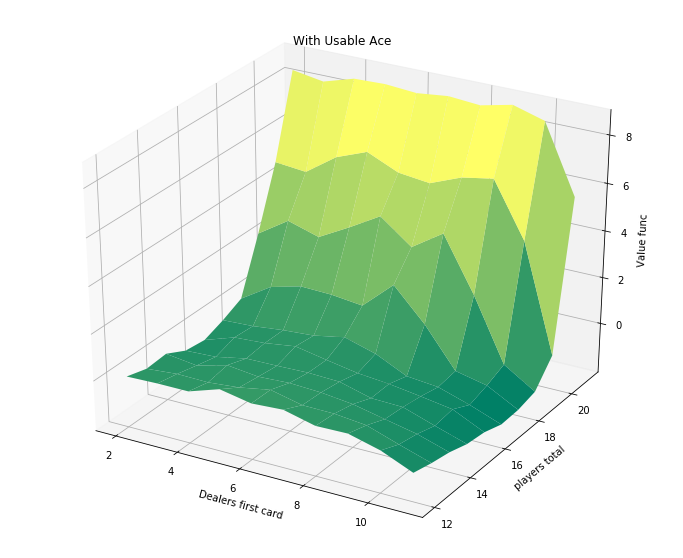

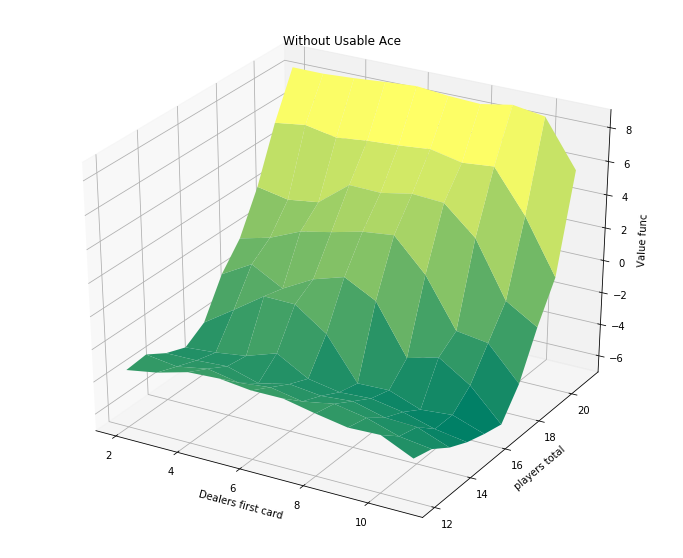

In [19]:
plot_value_function(value_function=value_function, with_ace = True)
plot_value_function(value_function=value_function, with_ace = False)

**Probability Model**

Now we want to assign a probability of hitting to each state, according to the optimal Q value function. And then calculate how much our human data matches this probability model. We use Maximum Likelihood Estimation as a measure of similarity between the modelled probabilities and the human data.

In [26]:
from read_data import *
import math
from scipy.special import comb
from scipy.optimize import fmin

def optimality_model(states, alpha):
    prob_hit = np.zeros(len(states), dtype = float)
    for state in valid_states:
        numerator = math.exp(alpha*q_value_table[state_to_index(state)]['hit'])
        denominator = math.exp(alpha*q_value_table[state_to_index(state)]['hit']) + math.exp(alpha*q_value_table[state_to_index(state)]['stand'])
        prob_hit[state_to_index(state)] = numerator/denominator
    return prob_hit

def compute_log_likelihood(T, H, p):
    p = p if p > 0.0 else 0.0+1e-10
    p = p if p < 1.0 else 1.0-1e-10
    result = math.log(comb(T, H)) + (H*math.log(p) + (T-H)*math.log(1.0-p))
    return result
    
def fit_optimality_model(alpha, human_data):
    probabilities = optimality_model(valid_states, alpha)
    total = 0
    for index,row in human_data.iterrows():
        total += compute_log_likelihood(row['Count'], row['HIT'], probabilities[state_to_index(row['State'])])
    return -1*total

data = get_human_results()
print("MLE for alpha = 1" + str(fit_optimality_model(1, data)))
minimizing_alpha = fmin(fit_optimality_model, 1.0, args=(data,))
print("The best fitted value of alpha" + str(minimizing_alpha))
fit_optimality_model(minimizing_alpha, data)

MLE for alpha = 11211.3198290902596
Optimization terminated successfully.
         Current function value: 262.243124
         Iterations: 16
         Function evaluations: 32
The best fitted value of alpha[0.07568359]


262.2431243246426